# Fantasy Draft Monte Carlo Visualization

This notebook loads and visualizes Monte Carlo simulation results from the draft optimizer.

## Generate Data First
Run this command to generate CSV files:
```bash
python dp_draft_optimizer_debug.py --export-csv --sims=1000
```

In [23]:
# Install required packages if not already installed
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
except ImportError:
    print("Installing visualization packages...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'matplotlib', 'seaborn'])
    import matplotlib.pyplot as plt
    import seaborn as sns

import pandas as pd
import numpy as np
from matplotlib.patches import Rectangle
import ast

plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

## Load Data

## 0. Underlying Probability Models

First, let's examine the probability models that drive the Monte Carlo simulation.

In [24]:
# Show the underlying probability models
print("="*70)
print("UNDERLYING PROBABILITY MODELS")
print("="*70)

print("\n1. OPPONENT SELECTION MODEL:")
print("-" * 40)
print("Base ranking weight: 1.0 / (rank + 1)")
print("Example ranking weights:")
for i in range(10):
    weight = 1.0 / (i + 1)
    print(f"  Rank {i+1:2d}: {weight:.3f} weight")

print("\n2. POSITION SCARCITY MULTIPLIERS:")
print("-" * 40)
print("Teams modify selection based on roster needs:")

position_weights = {
    'QB': "3.0x if need QB (0 on roster), 0.5x if have QB",
    'RB': "2.0x if need RB (<2 on roster), 1.0x otherwise", 
    'WR': "2.0x if need WR (<2 on roster), 1.0x otherwise",
    'TE': "2.5x if need TE (0 on roster), 0.5x if have TE"
}

for pos, desc in position_weights.items():
    print(f"  {pos}: {desc}")

print("\n3. RANDOMNESS MODEL:")
print("-" * 40)
print("Gaussian noise: Normal(mean=1.0, std=0.3)")
print("Final selection weight = rank_weight × position_weight × noise")
print("Minimum weight floor: 0.1 (prevents impossible selections)")

print("\n4. DRAFT ORDER MODEL:")
print("-" * 40)
print("Snake draft simulation:")
print("  Round 1,3,5...: Teams 1→14")  
print("  Round 2,4,6...: Teams 14→1")
print("  14 teams × 7 rounds = 98 picks simulated")

UNDERLYING PROBABILITY MODELS

1. OPPONENT SELECTION MODEL:
----------------------------------------
Base ranking weight: 1.0 / (rank + 1)
Example ranking weights:
  Rank  1: 1.000 weight
  Rank  2: 0.500 weight
  Rank  3: 0.333 weight
  Rank  4: 0.250 weight
  Rank  5: 0.200 weight
  Rank  6: 0.167 weight
  Rank  7: 0.143 weight
  Rank  8: 0.125 weight
  Rank  9: 0.111 weight
  Rank 10: 0.100 weight

2. POSITION SCARCITY MULTIPLIERS:
----------------------------------------
Teams modify selection based on roster needs:
  QB: 3.0x if need QB (0 on roster), 0.5x if have QB
  RB: 2.0x if need RB (<2 on roster), 1.0x otherwise
  WR: 2.0x if need WR (<2 on roster), 1.0x otherwise
  TE: 2.5x if need TE (0 on roster), 0.5x if have TE

3. RANDOMNESS MODEL:
----------------------------------------
Gaussian noise: Normal(mean=1.0, std=0.3)
Final selection weight = rank_weight × position_weight × noise
Minimum weight floor: 0.1 (prevents impossible selections)

4. DRAFT ORDER MODEL:
------------

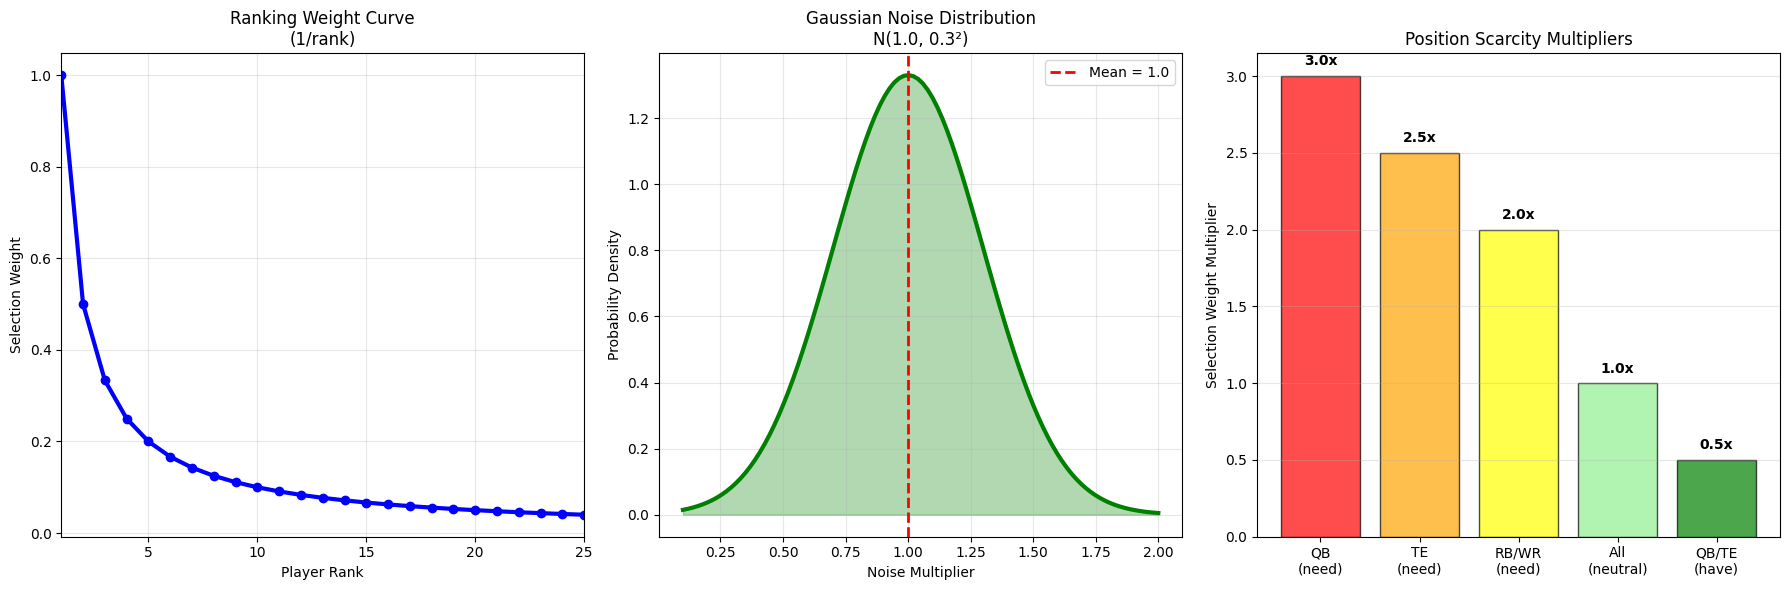

In [25]:
# Visualize the probability curves
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Ranking weight curve (1/rank)
ranks = np.arange(1, 26)
weights = 1.0 / ranks

axes[0].plot(ranks, weights, 'b-', linewidth=3, marker='o', markersize=6)
axes[0].set_xlabel('Player Rank')
axes[0].set_ylabel('Selection Weight')
axes[0].set_title('Ranking Weight Curve\n(1/rank)')
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim(1, 25)

# 2. Gaussian noise distribution
noise_values = np.linspace(0.1, 2.0, 100)
noise_prob = (1/np.sqrt(2*np.pi*0.3**2)) * np.exp(-0.5 * ((noise_values - 1.0)/0.3)**2)

axes[1].plot(noise_values, noise_prob, 'g-', linewidth=3)
axes[1].fill_between(noise_values, 0, noise_prob, alpha=0.3, color='green')
axes[1].axvline(x=1.0, color='red', linestyle='--', linewidth=2, label='Mean = 1.0')
axes[1].set_xlabel('Noise Multiplier')
axes[1].set_ylabel('Probability Density')
axes[1].set_title('Gaussian Noise Distribution\nN(1.0, 0.3²)')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

# 3. Position scarcity multipliers
positions = ['QB\n(need)', 'TE\n(need)', 'RB/WR\n(need)', 'All\n(neutral)', 'QB/TE\n(have)']
multipliers = [3.0, 2.5, 2.0, 1.0, 0.5]
colors = ['red', 'orange', 'yellow', 'lightgreen', 'green']

bars = axes[2].bar(positions, multipliers, color=colors, alpha=0.7, edgecolor='black')
axes[2].set_ylabel('Selection Weight Multiplier')
axes[2].set_title('Position Scarcity Multipliers')
axes[2].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, mult in zip(bars, multipliers):
    height = bar.get_height()
    axes[2].text(bar.get_x() + bar.get_width()/2., height + 0.05,
                f'{mult}x', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

EXAMPLE: OPPONENT SELECTION AT PICK 15 (Round 2, Team 2)

Team roster state: {'QB': 0, 'RB': 1, 'WR': 1, 'TE': 0}

Top 5 available players:
Player          Pos Rank RankWt  PosMult Noise  Final 
------------------------------------------------------------
Josh Allen      QB  #1   1.000   3.0     1.15   3.447 
Saquon Barkley  RB  #2   0.500   1.0     0.96   0.479 
Ja'Marr Chase   WR  #3   0.333   1.0     1.19   0.398 
Bijan Robinson  RB  #4   0.250   1.0     1.46   0.364 
Brock Bowers    TE  #5   0.200   2.5     0.93   0.465 

Selection probabilities:
  Josh Allen       66.9%
  Saquon Barkley    9.3%
  Ja'Marr Chase     7.7%
  Bijan Robinson    7.1%
  Brock Bowers      9.0%

Most likely selection: Josh Allen


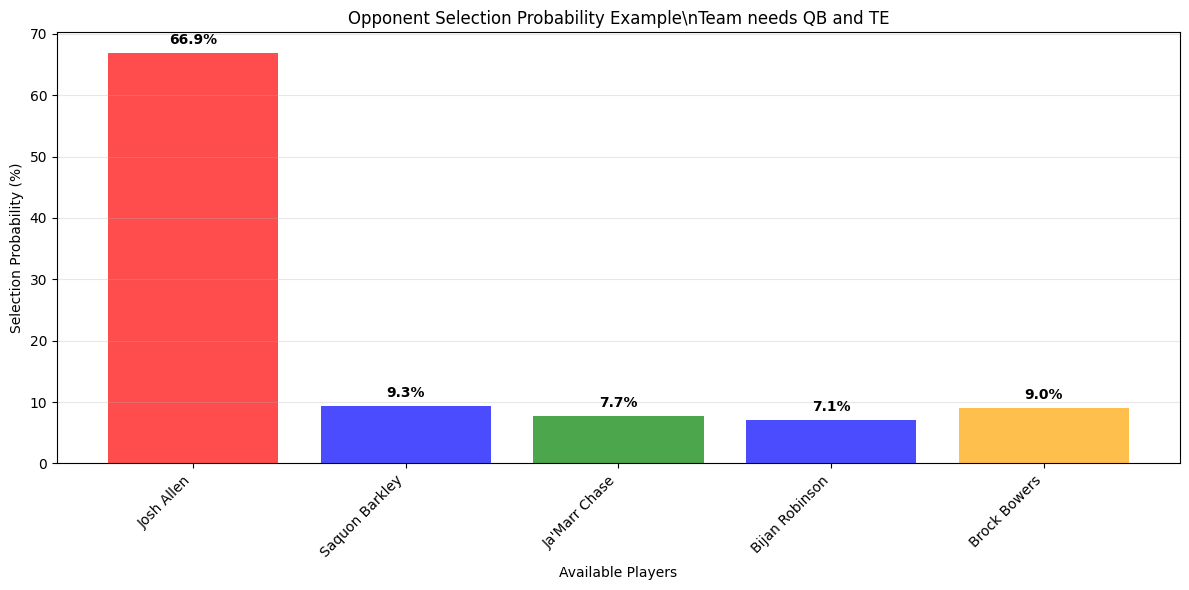

In [26]:
# Example: How opponent selection works for one pick
print("="*70)
print("EXAMPLE: OPPONENT SELECTION AT PICK 15 (Round 2, Team 2)")
print("="*70)

# Mock team roster state
team_roster = {'QB': 0, 'RB': 1, 'WR': 1, 'TE': 0}

print(f"\nTeam roster state: {team_roster}")
print("\nTop 5 available players:")

# Example top 5 available
available_players = [
    ("Josh Allen", "QB", 1),
    ("Saquon Barkley", "RB", 2), 
    ("Ja'Marr Chase", "WR", 3),
    ("Bijan Robinson", "RB", 4),
    ("Brock Bowers", "TE", 5)
]

position_multipliers = {
    'QB': 3.0,  # Need QB
    'RB': 1.0,  # Have 1 RB
    'WR': 1.0,  # Have 1 WR  
    'TE': 2.5   # Need TE
}

print(f"{'Player':<15} {'Pos':<3} {'Rank':<4} {'RankWt':<7} {'PosMult':<7} {'Noise':<6} {'Final':<6}")
print("-" * 60)

np.random.seed(42)  # For reproducible example
final_weights = []

for name, pos, rank in available_players:
    rank_weight = 1.0 / rank
    pos_mult = position_multipliers[pos]
    noise = max(0.1, np.random.normal(1.0, 0.3))
    final_weight = rank_weight * pos_mult * noise
    final_weights.append(final_weight)
    
    print(f"{name:<15} {pos:<3} #{rank:<3} {rank_weight:<7.3f} {pos_mult:<7.1f} {noise:<6.2f} {final_weight:<6.3f}")

# Show selection probabilities
total_weight = sum(final_weights)
probabilities = [w/total_weight for w in final_weights]

print(f"\nSelection probabilities:")
for i, (name, pos, rank) in enumerate(available_players):
    prob = probabilities[i]
    print(f"  {name:<15} {prob:>6.1%}")

# Show most likely pick
most_likely_idx = probabilities.index(max(probabilities))
most_likely = available_players[most_likely_idx][0]
print(f"\nMost likely selection: {most_likely}")

# Visualize as bar chart
plt.figure(figsize=(12, 6))
names = [name for name, _, _ in available_players]
colors = ['red', 'blue', 'green', 'blue', 'orange']  # Color by position

bars = plt.bar(names, [p*100 for p in probabilities], color=colors, alpha=0.7)
plt.xlabel('Available Players')
plt.ylabel('Selection Probability (%)')
plt.title('Opponent Selection Probability Example\\nTeam needs QB and TE')
plt.xticks(rotation=45, ha='right')

# Add percentage labels
for bar, prob in zip(bars, probabilities):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{prob:.1%}', ha='center', va='bottom', fontweight='bold')

plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

In [27]:
# Load CSV files
df_players = pd.read_csv('mc_player_survivals.csv')
df_positions = pd.read_csv('mc_position_summary.csv')
df_config = pd.read_csv('mc_config.csv')

# Extract configuration
num_sims = df_config['num_simulations'].iloc[0]
snake_picks = ast.literal_eval(df_config['snake_picks'].iloc[0])

print(f"Loaded data from {num_sims:,} Monte Carlo simulations")
print(f"Snake draft picks: {snake_picks}")
print(f"Players loaded: {len(df_players)}")

df_players.head()

Loaded data from 100 Monte Carlo simulations
Snake draft picks: [5, 24, 33, 52, 61, 80, 89]
Players loaded: 300


,player_name,position,fantasy_points,overall_rank,survival_pick_5,survival_pick_24,survival_pick_33,survival_pick_52,survival_pick_61,survival_pick_80,survival_pick_89
0,Ja'Marr Chase,WR,231.04,1,0.29,0.01,0.0,0.0,0.0,0.0,0.0
1,Bijan Robinson,RB,262.99,2,0.42,0.00,0.0,0.0,0.0,0.0,0.0
2,Justin Jefferson,WR,205.11,3,0.54,0.00,0.0,0.0,0.0,0.0,0.0
3,Saquon Barkley,RB,273.17,4,0.64,0.00,0.0,0.0,0.0,0.0,0.0
4,Jahmyr Gibbs,RB,259.23,5,0.69,0.01,0.0,0.0,0.0,0.0,0.0


## 1. Survival Probability Heatmaps

## 0.5. Simulation Scatter Plots

Let's visualize the actual simulation runs as scatter plots around the deterministic ESPN baseline.

Loaded 4100 individual simulation picks


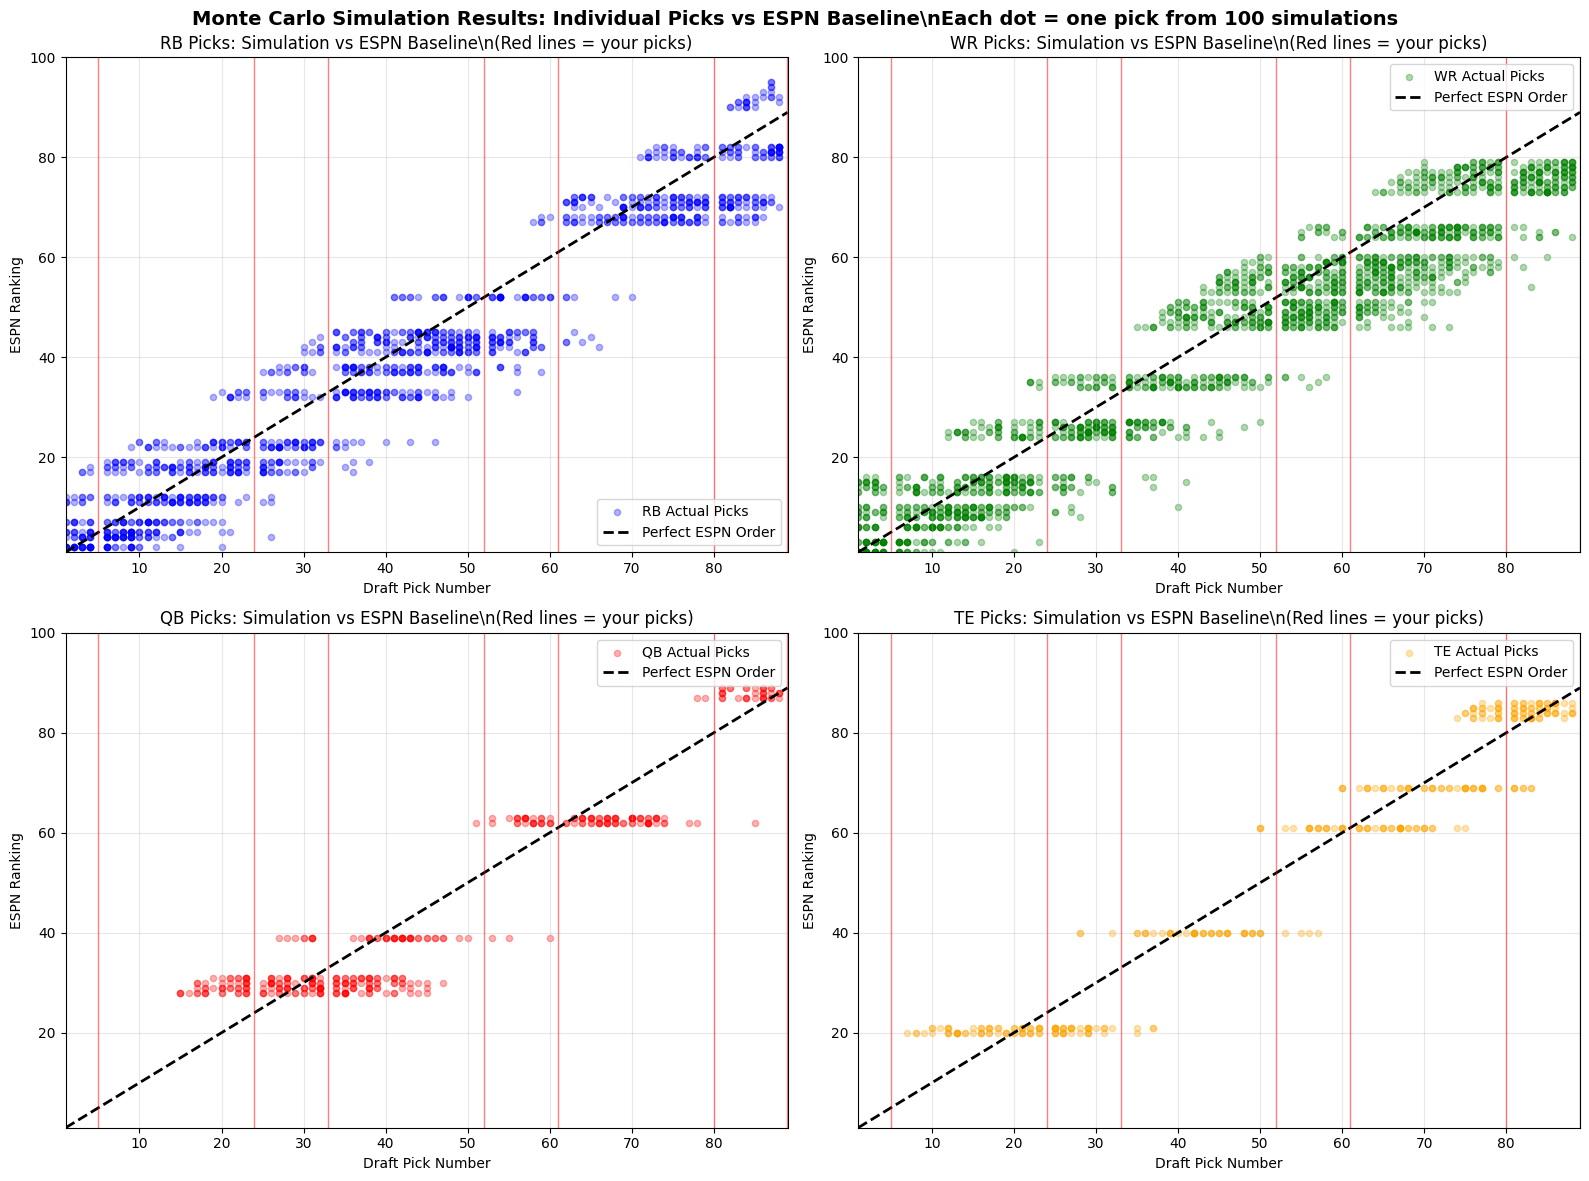

\nKey Observations:
  RB: picked close to ESPN rank (avg deviation: +2.6 picks)
  WR: picked close to ESPN rank (avg deviation: +3.7 picks)
  QB: picked close to ESPN rank (avg deviation: +1.0 picks)
  TE: picked close to ESPN rank (avg deviation: +0.7 picks)


In [28]:
# Load simulation picks data (if available)
try:
    df_sim_picks = pd.read_csv('mc_simulation_picks.csv')
    print(f"Loaded {len(df_sim_picks)} individual simulation picks")
    
    # Show deterministic ESPN baseline vs actual simulation picks
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    positions = ['RB', 'WR', 'QB', 'TE']
    colors = ['blue', 'green', 'red', 'orange']
    
    for i, (pos, color) in enumerate(zip(positions, colors)):
        ax = axes[i//2, i%2]
        
        # Filter simulation data for this position
        pos_picks = df_sim_picks[df_sim_picks['position'] == pos]
        
        if len(pos_picks) > 0:
            # Create scatter plot
            ax.scatter(pos_picks['pick_number'], pos_picks['espn_rank'], 
                      alpha=0.3, s=20, color=color, label=f'{pos} Actual Picks')
            
            # Add deterministic ESPN baseline (perfect order)
            espn_baseline_x = range(1, 90)
            espn_baseline_y = range(1, 90)
            ax.plot(espn_baseline_x, espn_baseline_y, 'k--', linewidth=2, 
                   label='Perfect ESPN Order')
            
            # Highlight your picks
            for pick in snake_picks:
                ax.axvline(x=pick, color='red', alpha=0.5, linestyle='-', linewidth=1)
            
            ax.set_xlabel('Draft Pick Number')
            ax.set_ylabel('ESPN Ranking')
            ax.set_title(f'{pos} Picks: Simulation vs ESPN Baseline\\n(Red lines = your picks)')
            ax.legend()
            ax.grid(True, alpha=0.3)
            ax.set_xlim(1, 89)
            ax.set_ylim(1, 100)
        else:
            ax.text(0.5, 0.5, f'No {pos} picks found', transform=ax.transAxes, 
                   ha='center', va='center', fontsize=14)
            ax.set_title(f'{pos} - No Data')
    
    plt.suptitle(f'Monte Carlo Simulation Results: Individual Picks vs ESPN Baseline\\n'
                f'Each dot = one pick from {num_sims} simulations', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Show position-specific analysis
    print("\\nKey Observations:")
    for pos in positions:
        pos_picks = df_sim_picks[df_sim_picks['position'] == pos]
        if len(pos_picks) > 0:
            # Calculate how much picks deviate from ESPN rank
            deviations = pos_picks['pick_number'] - pos_picks['espn_rank']
            avg_deviation = deviations.mean()
            std_deviation = deviations.std()
            
            if avg_deviation > 5:
                trend = "picked LATER than ESPN rank (position scarcity)"
            elif avg_deviation < -5:
                trend = "picked EARLIER than ESPN rank (position priority)"
            else:
                trend = "picked close to ESPN rank"
                
            print(f"  {pos}: {trend} (avg deviation: {avg_deviation:+.1f} picks)")
            
except FileNotFoundError:
    print("Simulation picks data not found.")
    print("Generate it first with: python dp_draft_optimizer_debug.py --export-simulations --sims=100")

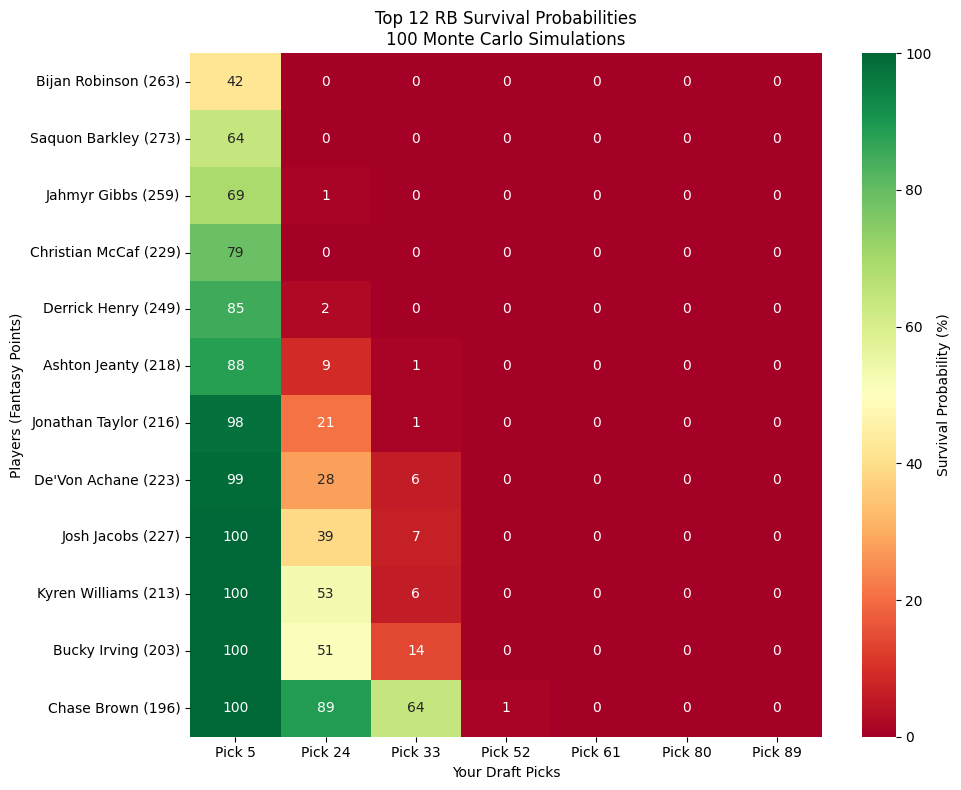

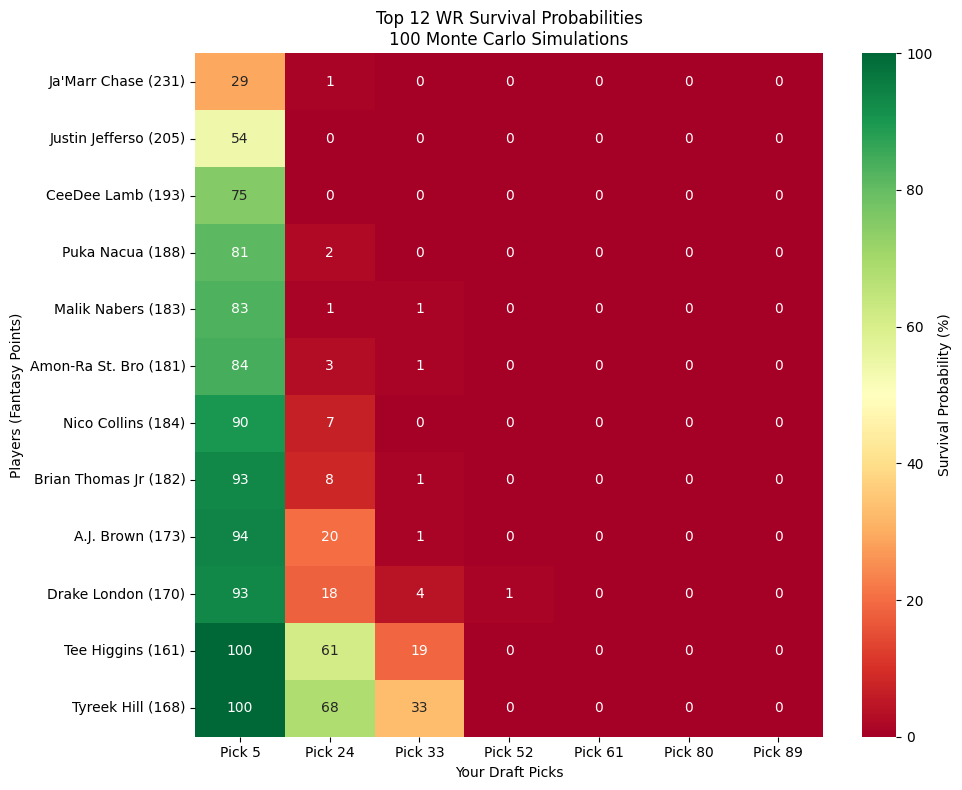

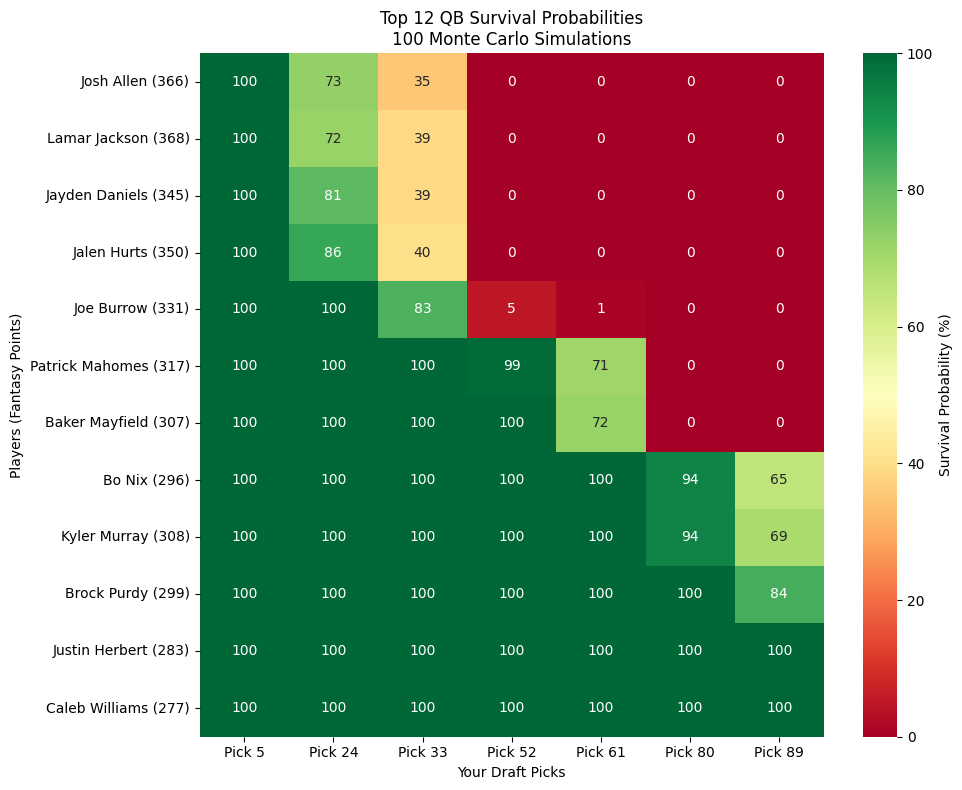

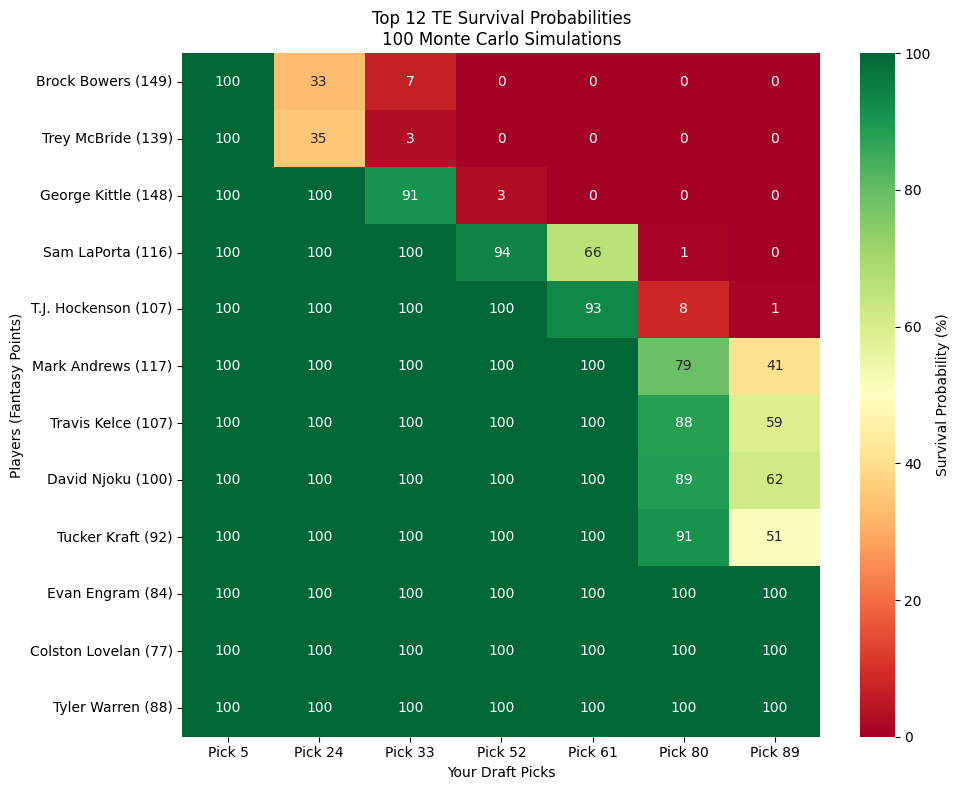

In [29]:
def plot_position_heatmap(position, top_n=12):
    """Create survival probability heatmap for a position."""
    pos_players = df_players[df_players['position'] == position].head(top_n)
    
    # Extract survival columns
    survival_cols = [f'survival_pick_{pick}' for pick in snake_picks]
    survival_data = pos_players[survival_cols].values * 100  # Convert to percentage
    
    # Create labels
    player_labels = [f"{name[:15]} ({pts:.0f})" 
                    for name, pts in zip(pos_players['player_name'], pos_players['fantasy_points'])]
    pick_labels = [f"Pick {pick}" for pick in snake_picks]
    
    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(survival_data, 
                xticklabels=pick_labels,
                yticklabels=player_labels,
                annot=True, 
                fmt='.0f',
                cmap='RdYlGn',
                cbar_kws={'label': 'Survival Probability (%)'},
                vmin=0, vmax=100)
    
    plt.title(f'Top {top_n} {position} Survival Probabilities\n{num_sims:,} Monte Carlo Simulations')
    plt.xlabel('Your Draft Picks')
    plt.ylabel('Players (Fantasy Points)')
    plt.tight_layout()
    return plt.gcf()

# Create heatmaps for each position
for pos in ['RB', 'WR', 'QB', 'TE']:
    plot_position_heatmap(pos)
    plt.show()

## 2. Position Scarcity Analysis

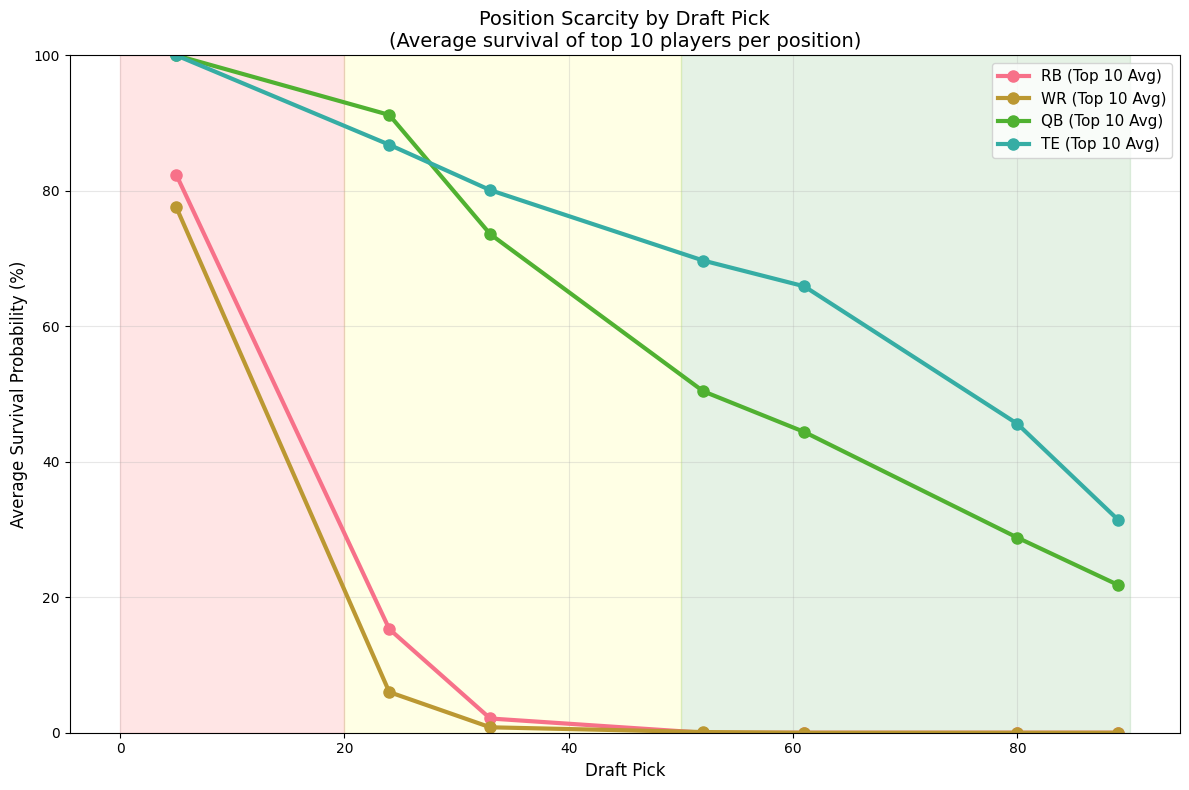

In [30]:
# Position scarcity over picks
plt.figure(figsize=(12, 8))

for pos in ['RB', 'WR', 'QB', 'TE']:
    pos_data = df_positions[df_positions['position'] == pos]
    plt.plot(pos_data['pick'], pos_data['avg_survival_top10'] * 100, 
             marker='o', linewidth=3, markersize=8, label=f'{pos} (Top 10 Avg)')

plt.xlabel('Draft Pick', fontsize=12)
plt.ylabel('Average Survival Probability (%)', fontsize=12)
plt.title('Position Scarcity by Draft Pick\n(Average survival of top 10 players per position)', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.ylim(0, 100)

# Add shaded regions for draft strategy insights
plt.axvspan(0, 20, alpha=0.1, color='red', label='Elite tier')
plt.axvspan(20, 50, alpha=0.1, color='yellow', label='Value tier')
plt.axvspan(50, 90, alpha=0.1, color='green', label='Deep tier')

plt.tight_layout()
plt.show()

## 3. Pick-Specific Player Availability


=== PICK 5 ANALYSIS ===


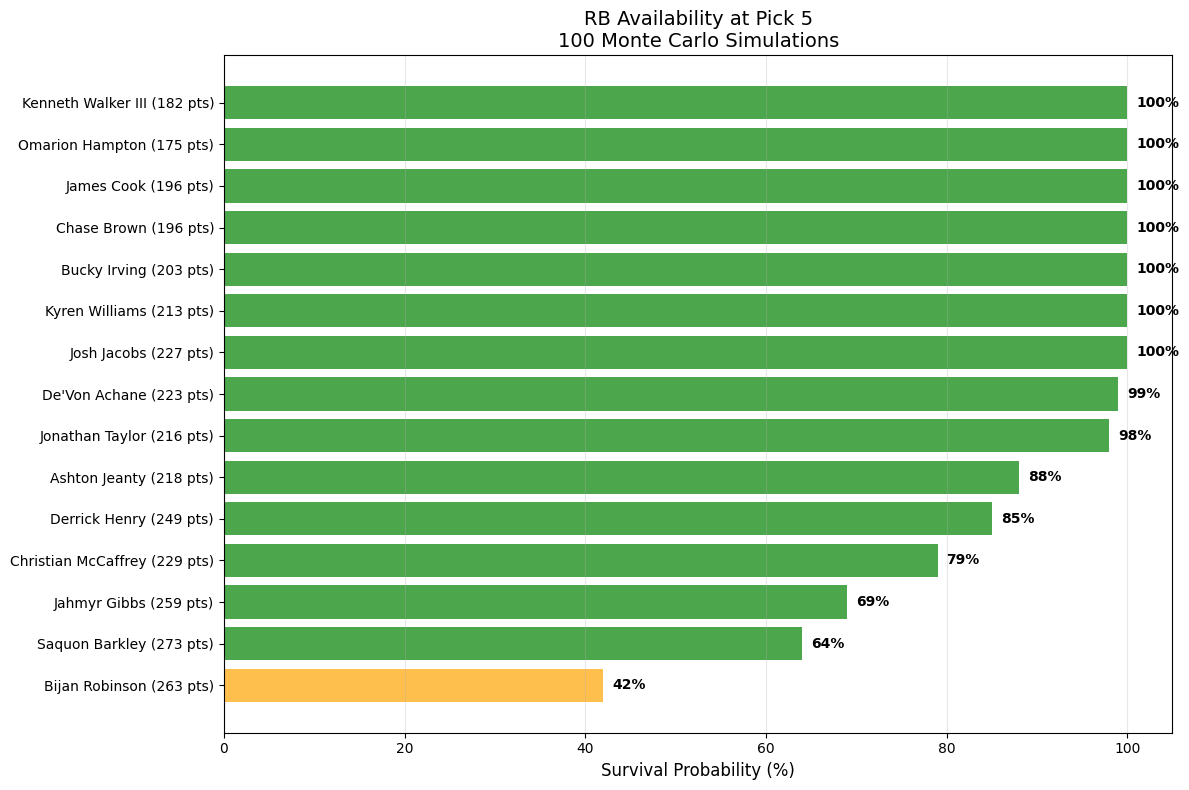

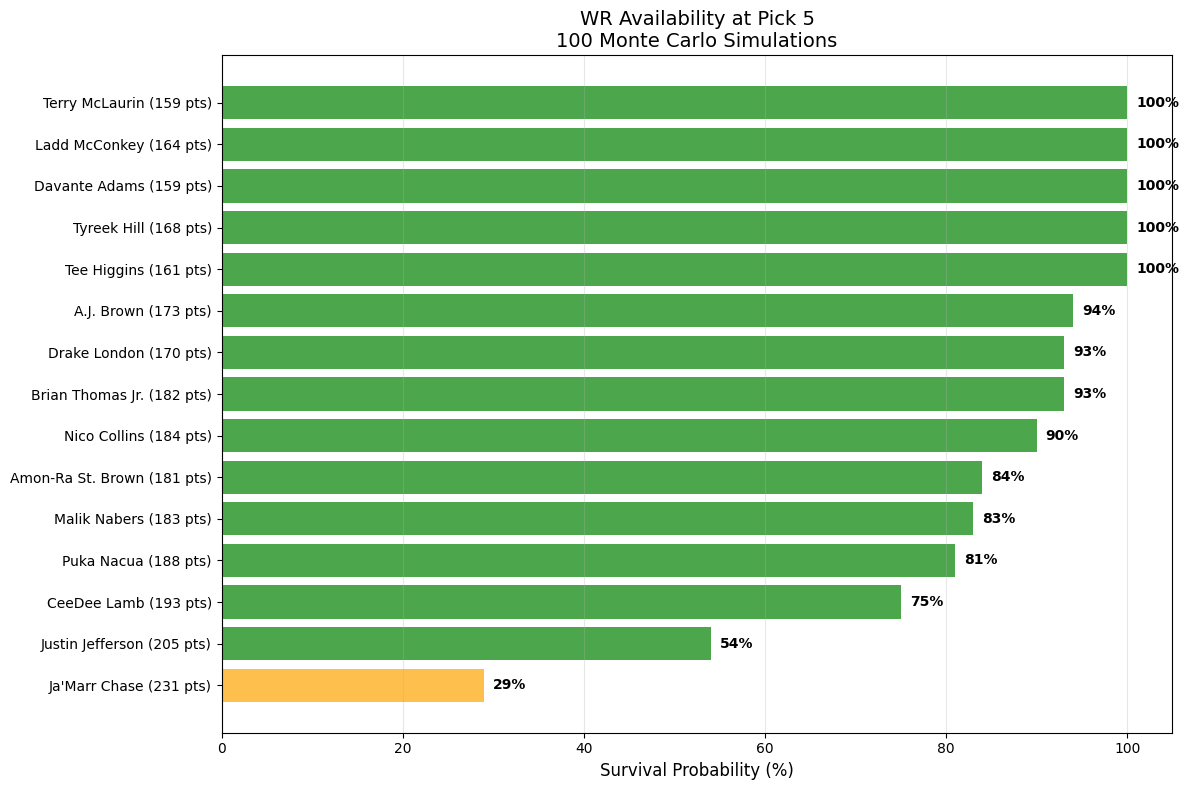


=== PICK 24 ANALYSIS ===


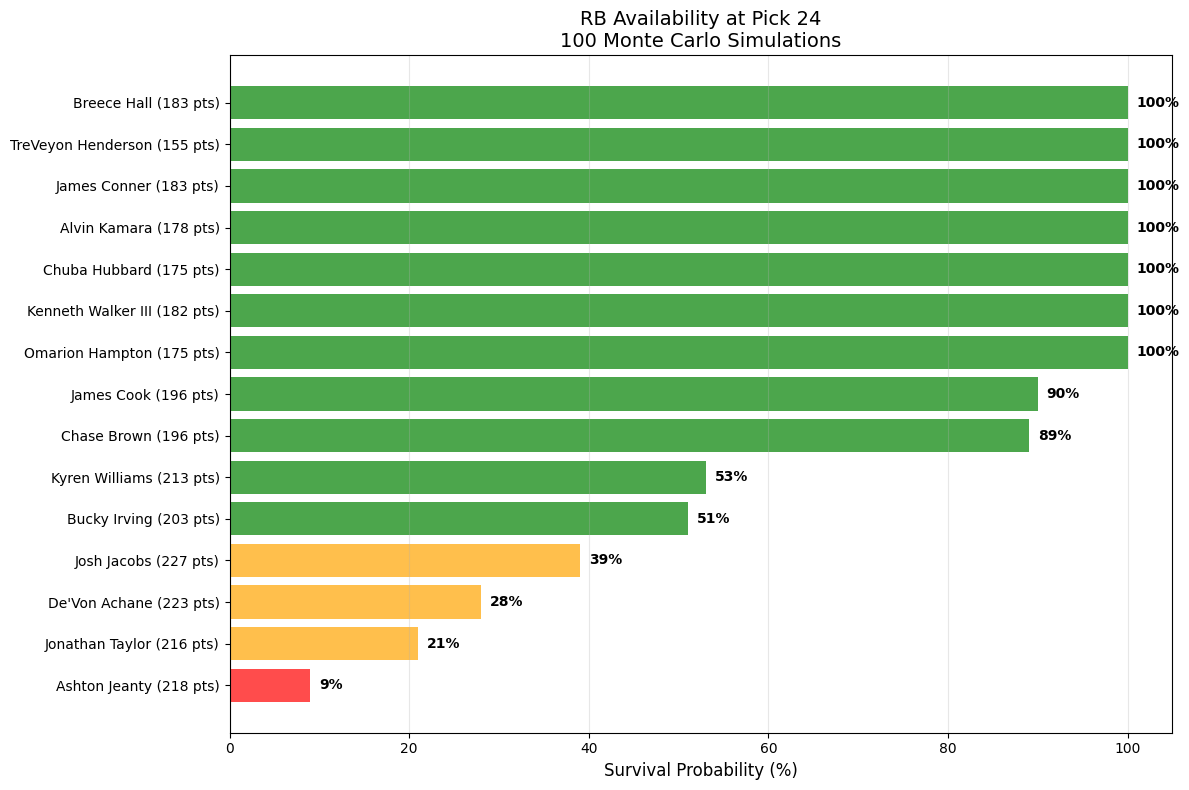

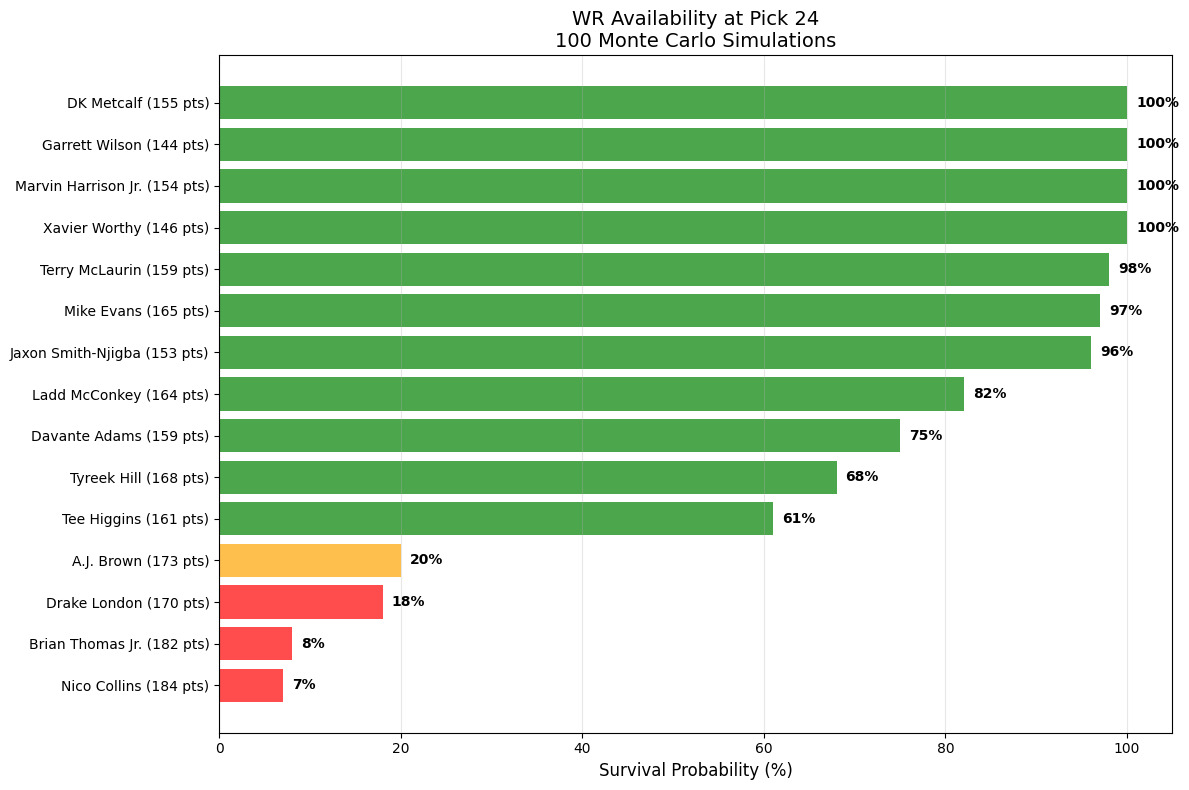


=== PICK 52 ANALYSIS ===


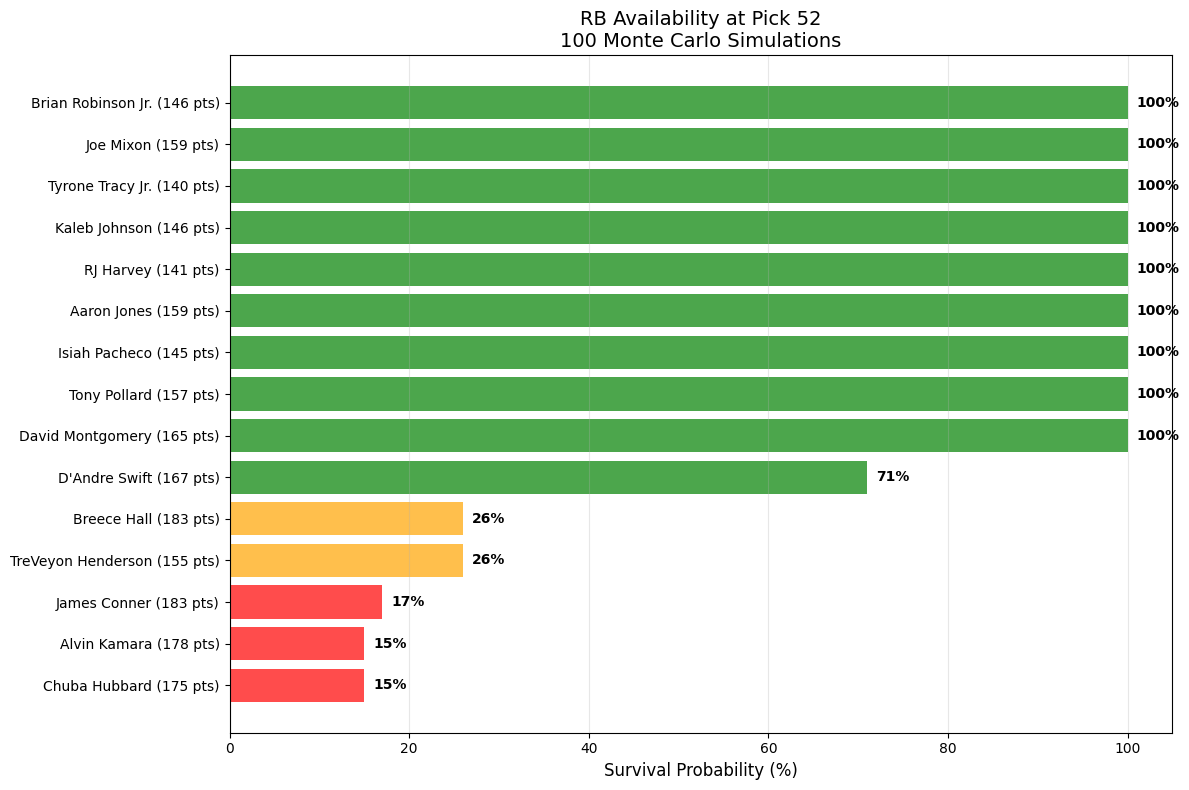

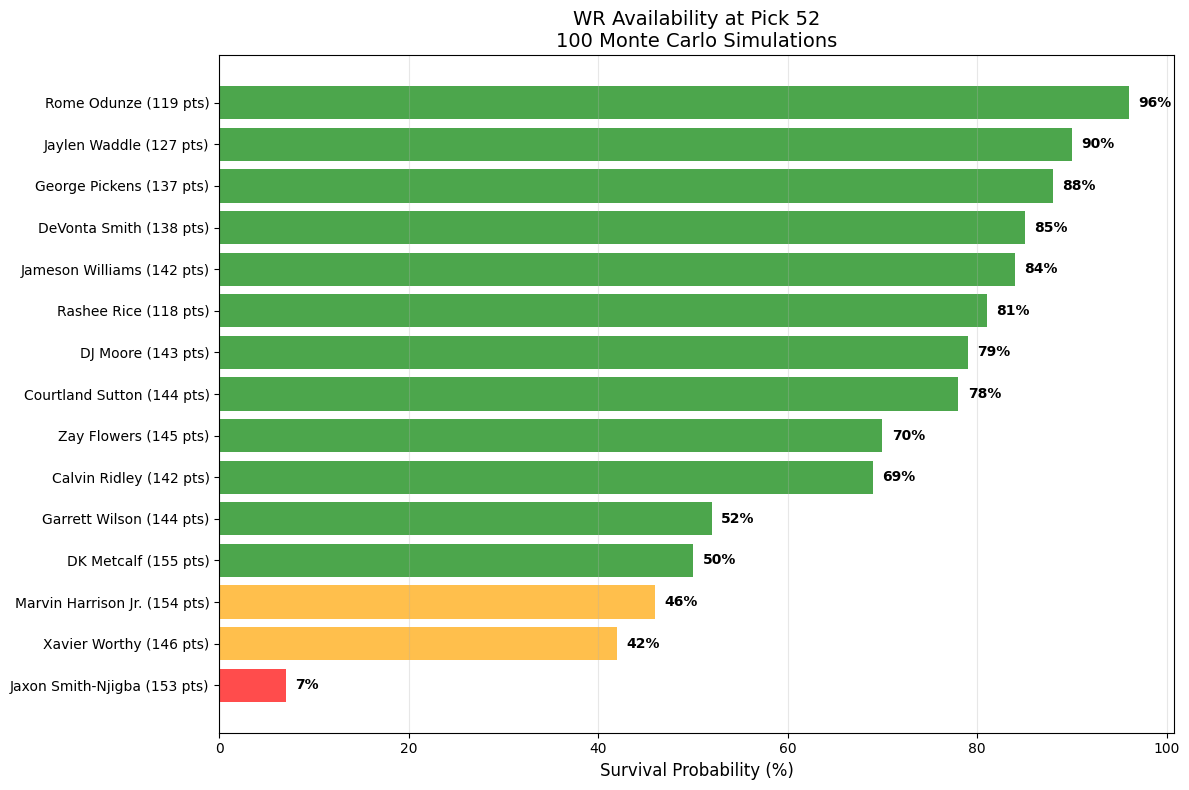

In [31]:
def plot_pick_availability(pick_num, position, min_survival=0.05):
    """Show which players are available at a specific pick."""
    pos_players = df_players[df_players['position'] == position].copy()
    survival_col = f'survival_pick_{pick_num}'
    
    # Filter players with meaningful survival probability
    available = pos_players[pos_players[survival_col] >= min_survival].head(15)
    available = available.sort_values(survival_col, ascending=True)  # Low to high for better viz
    
    if len(available) == 0:
        print(f"No {position} players have >{min_survival:.0%} survival at pick {pick_num}")
        return
    
    # Create horizontal bar chart
    plt.figure(figsize=(12, 8))
    
    colors = ['red' if x < 0.2 else 'orange' if x < 0.5 else 'green' 
              for x in available[survival_col]]
    
    bars = plt.barh(range(len(available)), available[survival_col] * 100, color=colors, alpha=0.7)
    
    # Add player names and fantasy points
    plt.yticks(range(len(available)), 
               [f"{name[:20]} ({pts:.0f} pts)" 
                for name, pts in zip(available['player_name'], available['fantasy_points'])])
    
    plt.xlabel('Survival Probability (%)', fontsize=12)
    plt.title(f'{position} Availability at Pick {pick_num}\n{num_sims:,} Monte Carlo Simulations', fontsize=14)
    plt.grid(axis='x', alpha=0.3)
    
    # Add percentage labels on bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + 1, bar.get_y() + bar.get_height()/2, 
                f'{width:.0f}%', ha='left', va='center', fontweight='bold')
    
    plt.tight_layout()
    return plt.gcf()

# Show availability at key picks
key_picks = [5, 24, 52]
for pick in key_picks:
    print(f"\n=== PICK {pick} ANALYSIS ===")
    for pos in ['RB', 'WR']:
        plot_pick_availability(pick, pos)
        plt.show()

## 4. Elite Player Tracking

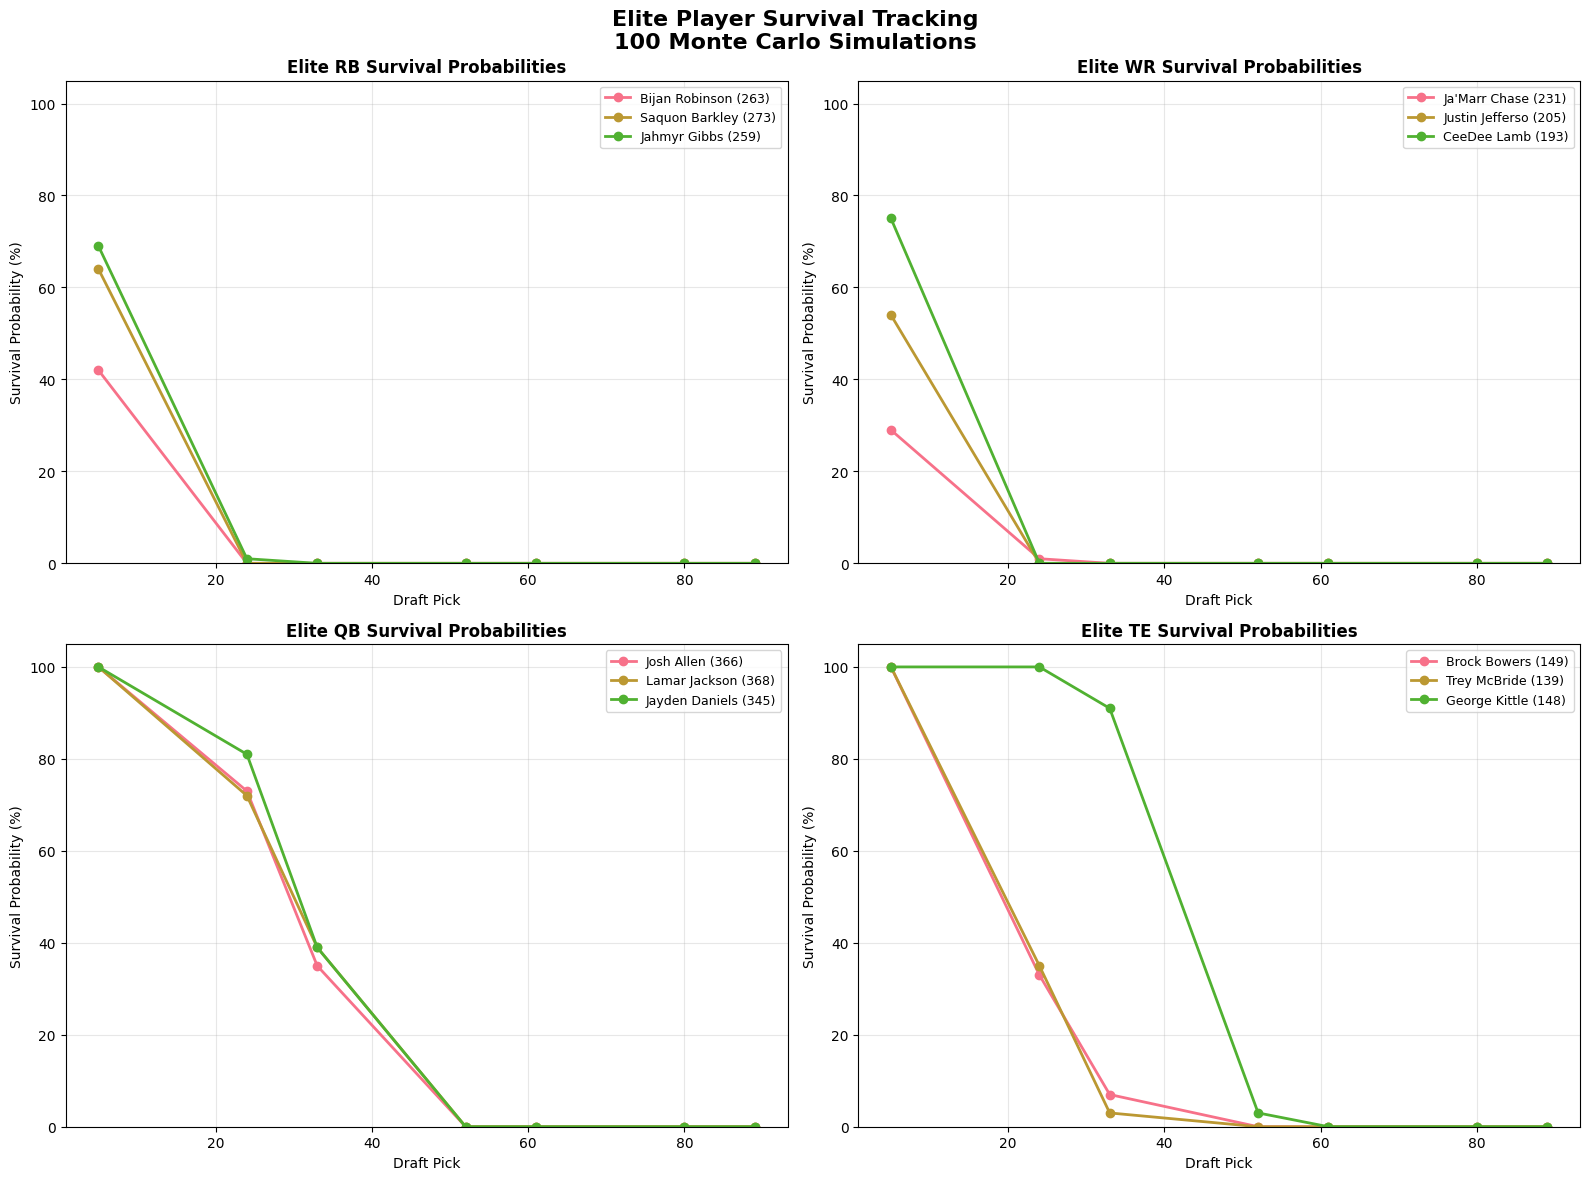

In [32]:
# Track survival of elite players across picks
elite_players = {
    'RB': ['Bijan Robinson', 'Saquon Barkley', 'Jahmyr Gibbs'],
    'WR': ['Ja\'Marr Chase', 'Justin Jefferson', 'CeeDee Lamb'],
    'QB': ['Josh Allen', 'Lamar Jackson', 'Jayden Daniels'],
    'TE': ['Brock Bowers', 'Trey McBride', 'George Kittle']
}

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, (pos, players) in enumerate(elite_players.items()):
    ax = axes[i]
    
    for player_name in players:
        player_data = df_players[df_players['player_name'] == player_name]
        if len(player_data) > 0:
            survival_vals = []
            for pick in snake_picks:
                col = f'survival_pick_{pick}'
                survival_vals.append(player_data[col].iloc[0] * 100)
            
            ax.plot(snake_picks, survival_vals, marker='o', linewidth=2, 
                   label=f"{player_name[:15]} ({player_data['fantasy_points'].iloc[0]:.0f})")
    
    ax.set_title(f'Elite {pos} Survival Probabilities', fontsize=12, fontweight='bold')
    ax.set_xlabel('Draft Pick')
    ax.set_ylabel('Survival Probability (%)')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 105)

plt.suptitle(f'Elite Player Survival Tracking\n{num_sims:,} Monte Carlo Simulations', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 5. Draft Strategy Insights

In [33]:
# Summary table of key insights
print("=== DRAFT STRATEGY INSIGHTS ===")
print(f"Based on {num_sims:,} Monte Carlo simulations\n")

for pick in snake_picks:
    print(f"PICK {pick}:")
    
    for pos in ['RB', 'WR', 'QB', 'TE']:
        pos_players = df_players[df_players['position'] == pos]
        survival_col = f'survival_pick_{pick}'
        
        # Find players with >20% survival
        good_options = pos_players[pos_players[survival_col] >= 0.2]
        
        if len(good_options) > 0:
            best_player = good_options.iloc[0]
            prob = best_player[survival_col]
            print(f"  {pos}: {best_player['player_name'][:20]:20} ({prob:.0%} survival)")
        else:
            # Show best available even if low probability
            best_available = pos_players.iloc[0] if len(pos_players) > 0 else None
            if best_available is not None:
                prob = best_available[survival_col]
                print(f"  {pos}: {best_available['player_name'][:20]:20} ({prob:.0%} survival - REACH)")
    print()

=== DRAFT STRATEGY INSIGHTS ===
Based on 100 Monte Carlo simulations

PICK 5:
  RB: Bijan Robinson       (42% survival)
  WR: Ja'Marr Chase        (29% survival)
  QB: Josh Allen           (100% survival)
  TE: Brock Bowers         (100% survival)

PICK 24:
  RB: Jonathan Taylor      (21% survival)
  WR: A.J. Brown           (20% survival)
  QB: Josh Allen           (73% survival)
  TE: Brock Bowers         (33% survival)

PICK 33:
  RB: Chase Brown          (64% survival)
  WR: Tyreek Hill          (33% survival)
  QB: Josh Allen           (35% survival)
  TE: George Kittle        (91% survival)

PICK 52:
  RB: TreVeyon Henderson   (26% survival)
  WR: Xavier Worthy        (42% survival)
  QB: Patrick Mahomes      (99% survival)
  TE: Sam LaPorta          (94% survival)

PICK 61:
  RB: D'Andre Swift        (23% survival)
  WR: Calvin Ridley        (24% survival)
  QB: Patrick Mahomes      (71% survival)
  TE: Sam LaPorta          (66% survival)

PICK 80:
  RB: Isiah Pacheco        (27

## 6. Custom Analysis

Use the cells below to explore specific questions about your draft strategy.

In [34]:
# Example: Find players with >50% survival at multiple picks
print("Players available at multiple picks (>50% survival):")
print("=" * 60)

for pos in ['RB', 'WR', 'QB', 'TE']:
    pos_players = df_players[df_players['position'] == pos]
    
    for _, player in pos_players.head(20).iterrows():
        available_picks = []
        for pick in snake_picks:
            survival = player[f'survival_pick_{pick}']
            if survival >= 0.5:
                available_picks.append(f"P{pick}({survival:.0%})")
        
        if len(available_picks) >= 2:  # Available at 2+ picks
            print(f"{pos:2} {player['player_name'][:25]:25} {' '.join(available_picks)}")
    print()

Players available at multiple picks (>50% survival):
RB Kyren Williams            P5(100%) P24(53%)
RB Bucky Irving              P5(100%) P24(51%)
RB Chase Brown               P5(100%) P24(89%) P33(64%)
RB James Cook                P5(100%) P24(90%) P33(70%)
RB Omarion Hampton           P5(100%) P24(100%) P33(85%)
RB Kenneth Walker III        P5(100%) P24(100%) P33(78%)
RB Chuba Hubbard             P5(100%) P24(100%) P33(90%)
RB Alvin Kamara              P5(100%) P24(100%) P33(98%)
RB James Conner              P5(100%) P24(100%) P33(98%)
RB TreVeyon Henderson        P5(100%) P24(100%) P33(98%)
RB Breece Hall               P5(100%) P24(100%) P33(100%)

WR Tee Higgins               P5(100%) P24(61%)
WR Tyreek Hill               P5(100%) P24(68%)
WR Davante Adams             P5(100%) P24(75%)
WR Ladd McConkey             P5(100%) P24(82%)
WR Terry McLaurin            P5(100%) P24(98%) P33(73%)
WR Mike Evans                P5(100%) P24(97%) P33(75%)
WR Jaxon Smith-Njigba        P5(100%) P2

In [35]:
# Export key insights to text file
with open('draft_insights.txt', 'w') as f:
    f.write(f"Fantasy Draft Monte Carlo Analysis\n")
    f.write(f"Generated from {num_sims:,} simulations\n")
    f.write(f"Snake picks: {snake_picks}\n\n")
    
    f.write("KEY INSIGHTS:\n")
    f.write("=" * 50 + "\n")
    
    for pick in snake_picks:
        f.write(f"\nPick {pick}:\n")
        for pos in ['RB', 'WR', 'QB', 'TE']:
            pos_players = df_players[df_players['position'] == pos]
            if len(pos_players) > 0:
                best = pos_players.iloc[0]
                survival = best[f'survival_pick_{pick}']
                f.write(f"  {pos}: {best['player_name']} ({survival:.0%})\n")

print("Draft insights exported to 'draft_insights.txt'")

Draft insights exported to 'draft_insights.txt'
